In [1]:
# No parameters required

# Growth curve analysis of validation mutants

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["svg.fonttype"] = "none"

## Specify paths

In [3]:
# Input
layout_path = "../growth_data/20240129_full_layout.tsv"
source_data = [
    "../growth_data/20240128_validations_DMS_control.xlsx",
    "../growth_data/20240128_validations_DMS_caspo.xlsx",
    "../growth_data/20240131_validations_DMS_mica.xlsx",
    "../growth_data/20240131_validations_DMS_ani.xlsx",
]
DMS_data = "../classified/BY4741_FKS1-HS1/refined_classification.csv"

# Output
df_outpath = "../growth_data/"
graph_outpath = "../graphs/"

## Get layout

In [4]:
layout = pd.read_csv(
    layout_path, sep="\t", header=0, dtype={"Sanger_validated": "boolean"}
)
layout

,plate,well,compound,aa_seq,genotype,clone,Sanger_validated
0,1,A1,none,LVLSLRDP,F639delta,2,False
1,1,B1,none,LVLSLRDP,F639delta,3,False
2,1,C1,none,FVLSLRDP,L40delta,3,False
3,1,D1,none,FVLSLRDP,L40delta,4,False
4,1,E1,none,FLLSLRDP,V641delta,3,False
...,...,...,...,...,...,...,...
315,4,D10,anidulafungin,QLVLSLRDP,F639Q,3,False
316,4,E10,anidulafungin,FLVLSLRDP,WT,1,True
317,4,F10,anidulafungin,FLVLSLRDP,WT,2,True
318,4,G10,anidulafungin,FLVLSLRDP,BY,1,True


In [5]:
print(
    "Unique genotypes validated by Sanger:\n",
    layout.loc[layout.Sanger_validated, "genotype"].unique(),
)

Unique genotypes validated by Sanger:
 ['F639C' 'L640D' 'L642G' 'P647Q' 'P647N' 'F639V' 'F639S' 'L642Y' 'L642F'
 'S643P' 'S643F' 'S643Y' 'S643C' 'L640K' 'V641S' 'L640G' 'D646W' 'F639D'
 'F639E' 'V641F' 'V641H' 'L642K' 'S643L' 'R645D' 'R645S' 'V641W' 'R645Q'
 'F639Q' 'WT' 'BY']


## Get plate reader data

In [6]:
def get_data(fpath):
    ### Import libraries
    import numpy as np
    from datetime import datetime, date, time

    ### Read excel file
    source_df = pd.read_excel(fpath, index_col=0, header=0, skiprows=26, skipfooter=36)

    ### Parse timepoints
    t0, t1 = source_df.iloc[[0, 1], 0]  # Get the first and second timepoints

    # Convert first timepoint from time (of the day) object to time duration (h)
    t0_h = (
        datetime.combine(date.today(), t0) - datetime.combine(date.today(), time.min)
    ).total_seconds() / 3600

    # Convert difference between second and first timepoint into duration in h (measurement interval)
    delta = (
        datetime.combine(date.today(), t1) - datetime.combine(date.today(), t0)
    ).total_seconds() / 3600

    # Rewrite column of timepoints using calculated values
    source_df["Time"] = np.arange(t0_h, t0_h + len(source_df.Time) * delta, delta)

    # Delete column with temperature
    source_df.drop(columns="T° 600", inplace=True)

    # Rename columns
    source_df.columns = [x.split("=")[-1] if "=" in x else x for x in source_df.columns]

    # Reshape
    longdf = source_df.melt(
        id_vars="Time", var_name="well", value_name="OD"
    )  # wide to long dataframe
    return longdf

In [7]:
df_list = []

for i, f in enumerate(source_data):
    df = get_data(f)
    df["plate"] = i + 1
    df_list.append(df)

fulldf = pd.concat(df_list, ignore_index=True)
fulldf

,Time,well,OD,plate
0,0.00,A1,0.116,1
1,0.25,A1,0.116,1
2,0.50,A1,0.117,1
3,0.75,A1,0.118,1
4,1.00,A1,0.119,1
...,...,...,...,...
110971,71.00,H12,NaN,4
110972,71.25,H12,NaN,4
110973,71.50,H12,NaN,4
110974,71.75,H12,NaN,4


## Annotate data

In [8]:
annotdf = fulldf.merge(right=layout[layout.Sanger_validated], on=["plate", "well"])
annotdf

,Time,well,OD,plate,compound,aa_seq,genotype,clone,Sanger_validated
0,0.00,A4,0.118,1,none,FLVLSLRDQ,P647Q,2,True
1,0.25,A4,0.118,1,none,FLVLSLRDQ,P647Q,2,True
2,0.50,A4,0.119,1,none,FLVLSLRDQ,P647Q,2,True
3,0.75,A4,0.120,1,none,FLVLSLRDQ,P647Q,2,True
4,1.00,A4,0.122,1,none,FLVLSLRDQ,P647Q,2,True
...,...,...,...,...,...,...,...,...,...
57795,71.00,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True
57796,71.25,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True
57797,71.50,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True
57798,71.75,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True


## Visualize growth curves

```
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

grid = sns.FacetGrid(data=annotdf, col = 'compound', hue='genotype', palette='hls')
grid.map(sns.lineplot, 'Time', 'OD')

grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('Time (h)', 'OD')
grid.add_legend(title = 'Genotype')
grid.fig.subplots_adjust(top=0.9)
grid.tight_layout()
```

## Calculate normalized area under the curve (AUC)

In [9]:
def get_auc(g):
    import numpy as np

    return np.trapezoid(g.OD)

In [10]:
aucdf = (
    annotdf[annotdf["Time"] <= 40]
    .groupby(["genotype", "aa_seq", "clone", "compound", "well"])[["OD"]]
    .apply(func=get_auc)
    .reset_index(name="auc")
)
aucdf

,genotype,aa_seq,clone,compound,well,auc
0,BY,FLVLSLRDP,1,anidulafungin,G10,22.6925
1,BY,FLVLSLRDP,1,caspofungin,G10,21.9170
2,BY,FLVLSLRDP,1,micafungin,G10,21.3405
3,BY,FLVLSLRDP,1,none,G10,147.2240
4,BY,FLVLSLRDP,2,anidulafungin,H10,29.2160
...,...,...,...,...,...,...
195,WT,FLVLSLRDP,1,none,E10,144.9465
196,WT,FLVLSLRDP,2,anidulafungin,F10,24.2550
197,WT,FLVLSLRDP,2,caspofungin,F10,20.9890
198,WT,FLVLSLRDP,2,micafungin,F10,22.4110


In [11]:
aggdf = (
    aucdf.groupby(["genotype", "aa_seq", "compound"])[["auc"]]
    .agg(auc=("auc", "mean"), auc_min=("auc", "min"), auc_max=("auc", "max"))
    .reset_index()
)
aggdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860


In [12]:
def get_l2fc(val, minv, maxv, comp, df):
    import numpy as np

    # Retrieve corresponding WT value for the condition
    wt = df.loc[(df.compound == comp) & (df.genotype == "BY"), "auc"].values

    # Make sure a single value was extracted
    if len(wt) == 1:
        # Return log2 fold-change for mean, min and max
        return np.log2(val / wt[0]), np.log2(minv / wt[0]), np.log2(maxv / wt[0])
    else:
        return "error"

In [13]:
aggdf["L2FC"], aggdf["L2FC_min"], aggdf["L2FC_max"] = zip(
    *aggdf.apply(
        lambda row: get_l2fc(row.auc, row.auc_min, row.auc_max, row.compound, aggdf),
        axis=1,
    )
)
aggdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160,0.000000,-0.193755,0.170788
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850,0.000000,-0.063360,0.060694
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110,0.000000,-0.173987,0.155244
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240,0.000000,-0.144249,0.131128
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930,2.244534,2.244534,2.244534
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860,2.463212,2.463212,2.463212
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215,0.775816,0.775816,0.775816
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070,0.080093,0.080093,0.080093
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770,2.463986,2.424386,2.502529
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860,2.565742,2.528028,2.602495


In [14]:
aggdf["min_yerr"] = aggdf["L2FC"] - aggdf["L2FC_min"]
aggdf["max_yerr"] = aggdf["L2FC_max"] - aggdf["L2FC"]
aggdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max,min_yerr,max_yerr
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160,0.000000,-0.193755,0.170788,0.193755,0.170788
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850,0.000000,-0.063360,0.060694,0.063360,0.060694
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110,0.000000,-0.173987,0.155244,0.173987,0.155244
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240,0.000000,-0.144249,0.131128,0.144249,0.131128
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930,2.244534,2.244534,2.244534,0.000000,0.000000
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860,2.463212,2.463212,2.463212,0.000000,0.000000
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215,0.775816,0.775816,0.775816,0.000000,0.000000
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070,0.080093,0.080093,0.080093,0.000000,0.000000
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770,2.463986,2.424386,2.502529,0.039601,0.038543
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860,2.565742,2.528028,2.602495,0.037714,0.036753


## Visualize log2 fold changes

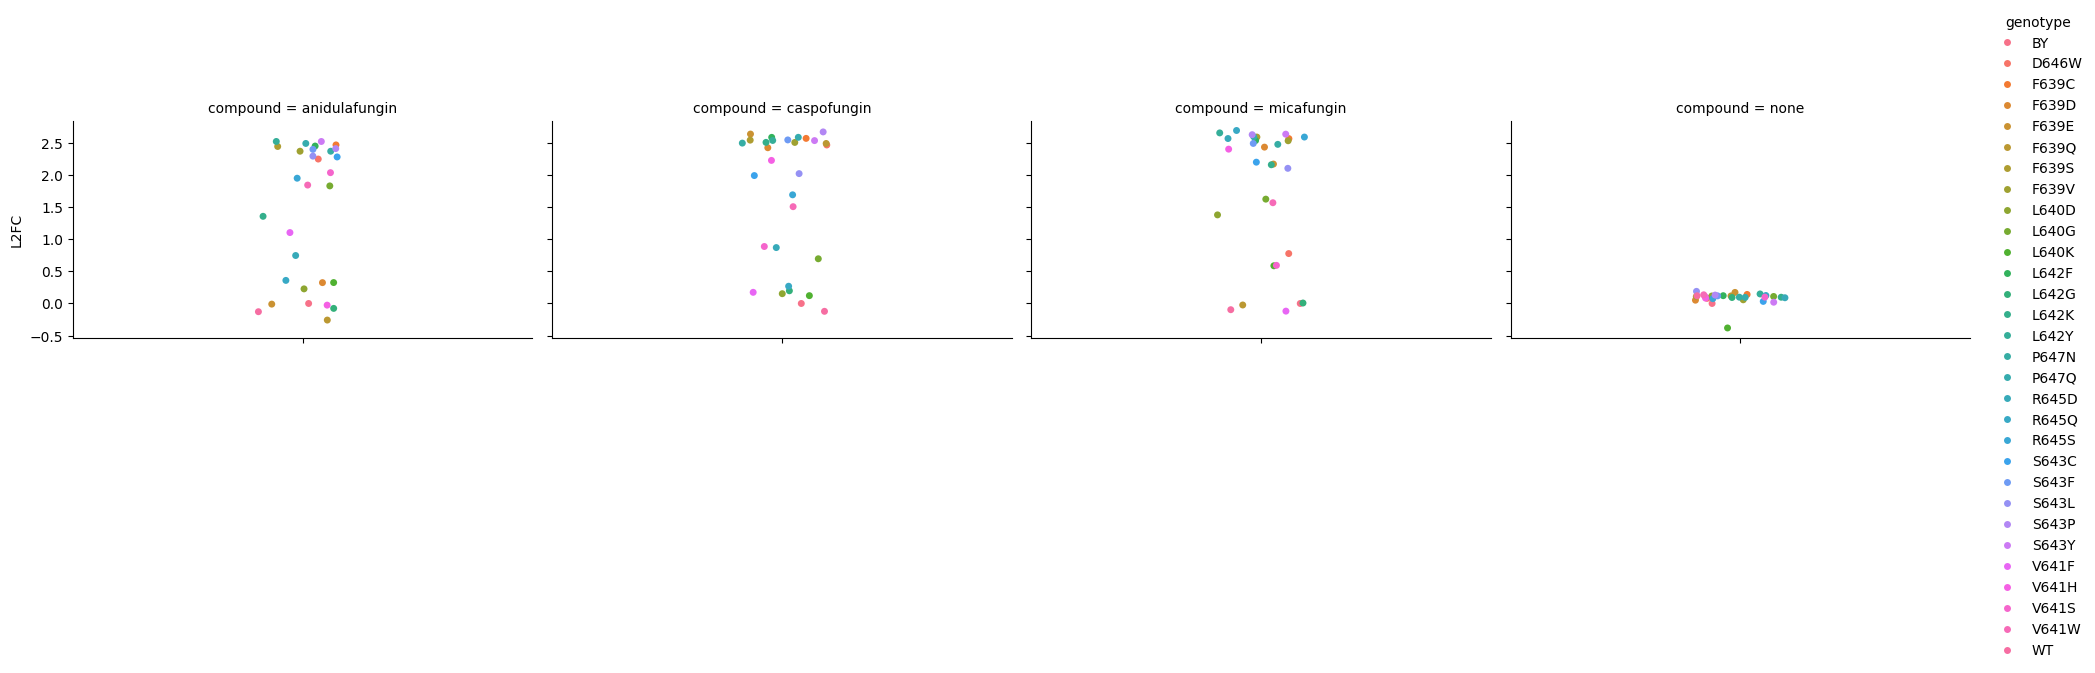

In [15]:
sns.catplot(aggdf, col="compound", y="L2FC", hue="genotype")

## Compare with DMS scores

In [16]:
DMS_aa = pd.read_csv(DMS_data, index_col=0)
DMS_aa

,aa_seq,Nham_aa,aa_pos,alt_aa,wt_aa,s,min_s,max_s,label,rclass,refined_class,sensres
compound,,,,,,,,,,,,
anidulafungin,*LVLSLRDP,1,639,*,F,0.058613,0.041132,0.041132,0.0,WT-like,WT-like,sensitive
anidulafungin,ALVLSLRDP,1,639,A,F,1.069379,0.033680,0.033680,2.0,intermediary,intermediary,resistant
anidulafungin,DLVLSLRDP,1,639,D,F,-0.062652,0.087959,0.087959,0.0,WT-like,WT-like,sensitive
anidulafungin,ELVLSLRDP,1,639,E,F,0.364873,0.096939,0.096939,0.0,WT-like,WT-like,sensitive
anidulafungin,F*VLSLRDP,1,640,*,L,0.087876,0.059328,0.059328,0.0,WT-like,WT-like,sensitive
...,...,...,...,...,...,...,...,...,...,...,...,...
none,SLVLSLRDP,1,639,S,F,0.006572,0.002929,0.002929,0.0,WT-like,WT-like,sensitive
none,TLVLSLRDP,1,639,T,F,-0.158020,0.041214,0.041214,1.0,slightly deleterious,slightly deleterious,sensitive
none,VLVLSLRDP,1,639,V,F,0.024330,0.013810,0.013810,0.0,WT-like,WT-like,sensitive


In [17]:
corrdf = aggdf.merge(right=DMS_aa, on=["compound", "aa_seq"])
corrdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max,min_yerr,...,aa_pos,alt_aa,wt_aa,s,min_s,max_s,label,rclass,refined_class,sensres
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160,0.000000,-0.193755,0.170788,0.193755,...,not-applicable,not-applicable,not-applicable,-0.113210,0.011200,0.011200,0.0,WT-like,WT-like,sensitive
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850,0.000000,-0.063360,0.060694,0.063360,...,not-applicable,not-applicable,not-applicable,-0.087817,0.009509,0.009509,2.0,WT-like,WT-like,sensitive
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110,0.000000,-0.173987,0.155244,0.173987,...,not-applicable,not-applicable,not-applicable,-0.046464,0.003814,0.003814,0.0,WT-like,WT-like,sensitive
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240,0.000000,-0.144249,0.131128,0.144249,...,not-applicable,not-applicable,not-applicable,-0.000829,0.002996,0.002996,0.0,WT-like,WT-like,sensitive
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930,2.244534,2.244534,2.244534,0.000000,...,646,W,D,1.085779,0.011258,0.011258,2.0,intermediary,intermediary,resistant
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860,2.463212,2.463212,2.463212,0.000000,...,646,W,D,1.199261,0.037984,0.037984,1.0,resistant,resistant,resistant
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215,0.775816,0.775816,0.775816,0.000000,...,646,W,D,-0.463966,0.105394,0.105394,0.0,WT-like,WT-like,sensitive
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070,0.080093,0.080093,0.080093,0.000000,...,646,W,D,0.040391,0.003159,0.003159,0.0,WT-like,WT-like,sensitive
8,F639D,DLVLSLRDP,anidulafungin,32.48950,31.3625,33.6165,0.324003,0.273070,0.373199,0.050933,...,639,D,F,-0.062652,0.087959,0.087959,0.0,WT-like,WT-like,sensitive
9,F639D,DLVLSLRDP,caspofungin,122.58725,121.8750,123.2995,2.420326,2.411920,2.428684,0.008407,...,639,D,F,1.189272,0.017221,0.017221,1.0,resistant,resistant,resistant


<>:77: SyntaxWarning: invalid escape sequence '\i'
<>:77: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_118899/3212652083.py:77: SyntaxWarning: invalid escape sequence '\i'
  0.3, -0.5, rf"$\rho$ = {sr:.2f}" + "\n$\it{p}$-val = " + f"{sp:.1e}", ha="left"


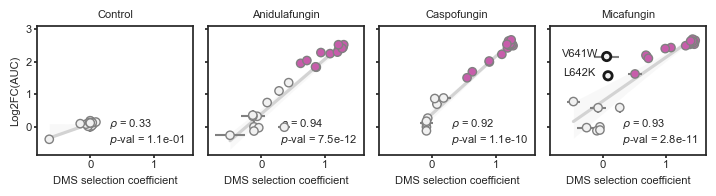

In [18]:
sns.set_theme(
    rc={
        "font.family": "Arial",
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "xtick.major.pad": 2,
        "ytick.major.pad": 2,
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.major.size": 2,
        "ytick.major.size": 2,
    },
    style="ticks",
)

lcomp = ["none", "anidulafungin", "caspofungin", "micafungin"]
comp_dict = {
    "caspofungin": "Caspofungin",
    "micafungin": "Micafungin",
    "anidulafungin": "Anidulafungin",
    "none": "Control",
}
classes = ["resistant", "sensitive", "deleterious"]
class_palette = ["#C75DAB", "#F1F1F1", "#009B9E"]
class_cmap = dict(zip(classes, class_palette))

# Initialize list to save linear regression parameters for each condition
reglist = []

grid = sns.lmplot(
    corrdf,
    x="s",
    y="L2FC",
    col="compound",
    col_order=lcomp,
    markers="none",  # dots are redrawn with color = resistance class
    # note: i've tried coloring the markers using scatter_kws, doesn't work
    facet_kws={"despine": False},
    line_kws={"color": "lightgrey"},
    height=2,
    aspect=0.9,
)

for i, c in enumerate(lcomp):
    graphdf = corrdf[corrdf.compound == c]
    grid.axes[0][i].title.set_text(comp_dict[c])

    # Drawing error bars
    grid.axes[0][i].errorbar(
        x=graphdf.s,
        y=graphdf.L2FC,
        xerr=[graphdf.min_s, graphdf.max_s],
        yerr=[graphdf.min_yerr, graphdf.max_yerr],
        fmt="none",
        ecolor="grey",  # only error bars, no dots
    )

    # Drawing dots, colored by their classification (resistant, WT-like, etc)
    grid.axes[0][i].scatter(
        x=graphdf.s,
        y=graphdf.L2FC,
        c=graphdf.sensres.map(class_cmap),
        ec="grey",
        zorder=100,
    )

    # Calculate and display Spearman correlation coefficient
    from scipy import stats

    sr, sp = stats.spearmanr(graphdf.s, graphdf.L2FC)
    grid.axes[0][i].text(
        0.3, -0.5, rf"$\rho$ = {sr:.2f}" + "\n$\it{p}$-val = " + f"{sp:.1e}", ha="left"
    )

    # I am leaving some unused code below to compare linear regression with seaborn (statsmodels OLS) and sklearn
    # but ultimately I use the regression done by seaborn (statsmodels OLS)
    # then I fetch the slope and intercept from seaborn drawn lines and append them to a dataframe

    # Perform linear regression using sklearn package
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression

    X = graphdf.s.values.reshape(-1, 1)
    y = graphdf.L2FC.values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=6
    )  # train on 20% of dataset
    reg = LinearRegression().fit(X_train, y_train)

    # Extract slope and intercept from sklearn Linear Regression model
    slopeSK = reg.coef_.flatten()[0]
    interceptSK = reg.intercept_[0]

    # Extract slope and intercept from seaborn lmplot (statsmodels OLS)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        x=grid.axes[0][i].get_lines()[0].get_xdata(),
        y=grid.axes[0][i].get_lines()[0].get_ydata(),
    )

    # Save slope and intercept for each condition in a list -> append to master list
    reglist.append([c, slope, intercept])

# Highlighting interesting cases
int_mut = ["V641W", "L642K"]
deviating_df = corrdf[
    (corrdf.compound == "micafungin") & (corrdf.genotype.isin(int_mut))
]
grid.axes[0][3].scatter(
    x=deviating_df.s,
    y=deviating_df.L2FC,
    c=deviating_df.sensres.map(class_cmap),
    ec="k",
    lw=2,
    zorder=200,
)
# .. and label them
for i, m in enumerate(int_mut):
    grid.axes[0][3].annotate(
        m,
        (deviating_df.s.values[i], deviating_df.L2FC.values[i]),  # x  # y
        xytext=(-4, 0),  # distance of text label from xy coords
        textcoords="offset fontsize",  # xytext coords given in fontsize
    )

grid.set_axis_labels("DMS selection coefficient", "Log2FC(AUC)")

# Convert list of list to dataframe
regdf = pd.DataFrame(reglist, columns=["compound", "slope", "intercept"])

plt.savefig(f"{graph_outpath}/validations.svg", format="svg", dpi=300)

In [19]:
regdf

,compound,slope,intercept
0,none,0.680686,0.098162
1,anidulafungin,1.674156,0.394837
2,caspofungin,1.756330,0.395698
3,micafungin,1.349998,0.790338


In [20]:
def get_estimate_DMS_score(v, r, df):
    # Merge row and dataframe containing linear regression parameters
    merg = pd.merge(r.to_frame().T, df, how="left", on="compound")

    # Get slope and intercept for this condition
    s = merg.slope[0]
    i = merg.intercept[0]

    # Return corrected value
    return (v - i) / s

In [21]:
# Mutants for which we need to estimate the DMS score
mut_no_DMS = [x for x in aggdf.genotype.unique() if x not in corrdf.genotype.unique()]
print(mut_no_DMS)

['F639C', 'L640D', 'L642G', 'P647N', 'P647Q']


In [22]:
aggdf["s"] = aggdf.apply(
    lambda row: get_estimate_DMS_score(row.L2FC, row, regdf), axis=1
)
rescued_df = aggdf[aggdf.genotype.isin(mut_no_DMS + ["V641W", "L642K"])][
    ["compound", "genotype", "aa_seq", "s"]
]
rescued_df["Nham_aa"] = 1
rescued_df["aa_pos"] = rescued_df["genotype"].map(lambda x: x[1:4])
rescued_df["alt_aa"] = rescued_df["genotype"].map(lambda x: x[-1])
rescued_df["wt_aa"] = rescued_df["genotype"].map(lambda x: x[0])
rescued_df[["compound", "aa_seq", "Nham_aa", "aa_pos", "alt_aa", "wt_aa", "s"]].to_csv(
    f"{df_outpath}/validation_DMS_missing_estimates.csv", index=False
)
rescued_df

,compound,genotype,aa_seq,s,Nham_aa,aa_pos,alt_aa,wt_aa
8,anidulafungin,F639C,CLVLSLRDP,1.235936,1,639,C,F
9,caspofungin,F639C,CLVLSLRDP,1.235556,1,639,C,F
10,micafungin,F639C,CLVLSLRDP,1.312268,1,639,C,F
11,none,F639C,CLVLSLRDP,0.062124,1,639,C,F
32,anidulafungin,L640D,FDVLSLRDP,-0.100225,1,640,D,L
33,caspofungin,L640D,FDVLSLRDP,-0.138673,1,640,D,L
34,micafungin,L640D,FDVLSLRDP,0.434417,1,640,D,L
35,none,L640D,FDVLSLRDP,0.026358,1,640,D,L
48,anidulafungin,L642G,FLVGSLRDP,-0.281357,1,642,G,L
49,caspofungin,L642G,FLVGSLRDP,-0.112982,1,642,G,L
